In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Problem Statement:

The goal of this competition is to leverage Generative Adversarial Networks (GANs) to generate images in the style of the renowned artist Claude Monet. Using a provided dataset of Monet paintings, we are tasked with developing a GAN that can produce 7,000 to 10,000 Monet-style images.

Challenge Overview:

Dataset:

The competition dataset includes images of Monet paintings.

GAN Architecture:

Implement a GAN architecture with at least two neural networks: a generator and a discriminator.
The generator creates images, mimicking Monet's style, while the discriminator distinguishes between real Monet paintings and generated images.
Training Process:

Train the GAN models in a competitive manner, where the generator aims to create realistic Monet-style images to deceive the discriminator.
Experiment with different architectures, hyperparameters, and training strategies to optimize the performance of the GAN.
Evaluation Metric:

Submissions are evaluated using MiFID (Memorization-informed Fréchet Inception Distance), a modification of FID.
The smaller the MiFID score, the better the quality of the generated images.
Submission Requirements:

Generate 7,000 to 10,000 Monet-style images in JPG format.
Each image should be sized 256x256 pixels (RGB).
Zip the generated images into a single file named "images.zip."
Run-time Constraints:

The competition provides run-time limits for CPU, GPU, and TPU notebooks.
Ensure that your GAN training process adheres to these limits.
Key Considerations:

The competition emphasizes the use of generative methods; direct submission of existing Monet paintings or altered versions is against the spirit of the competition.
Collaborate and engage with the competition community for insights, discussions, and shared experiences.
Regularly monitor and iterate on the GAN model based on the training progress and evaluation results.
Expected Output:

We need to submit a zip file named "images.zip" containing the generated Monet-style images. The submitted images will be evaluated based on the MiFID score, with lower scores indicating higher quality and fidelity to Monet's style.



In [2]:
import warnings
warnings.simplefilter('ignore')
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image as Image
import cv2

# Exploratory Data Analysis (EDA) Procedure for Monet Painting Dataset:

Exploratory Data Analysis is crucial for understanding the characteristics of the dataset and gaining insights into its structure. Here's an EDA procedure for the Monet painting dataset:

# Loading the Dataset:
Load the Monet painting dataset using appropriate libraries (e.g., TensorFlow, PyTorch, OpenCV).
Checking the dimensions, format, and number of images in the dataset.

In [3]:
monettfrec_filenames = tf.io.gfile.glob("/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec")
print("Monet TFReord Files: ", len(monettfrec_filenames))

phototfrec_filenames = tf.io.gfile.glob("/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec")
print('Photo TFRecord Files:', len(phototfrec_filenames))

print(monettfrec_filenames[0])



Monet TFReord Files:  5
Photo TFRecord Files: 20
/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec


In [4]:
monetJPG_filenames = tf.io.gfile.glob("/kaggle/input/gan-getting-started/monet_jpg/*.jpg")
print("Monet JPG Files: ", len(monetJPG_filenames))

photoJPG_filenames = tf.io.gfile.glob("/kaggle/input/gan-getting-started/photo_jpg/*.jpg")
print('Photo JPG Files:', len(photoJPG_filenames))

print(monetJPG_filenames[0])
print(photoJPG_filenames[0])

Monet JPG Files:  300
Photo JPG Files: 7038
/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/photo_jpg/fb97febc5f.jpg


(256, 256, 3)


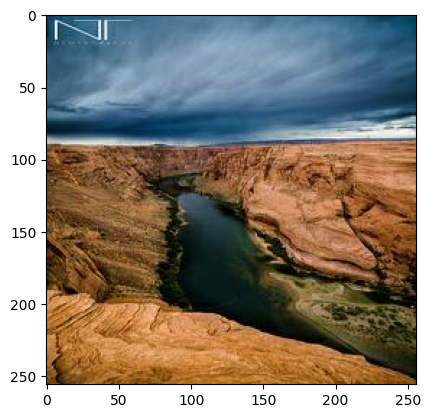

In [5]:
image_monet = Image.imread("/kaggle/input/gan-getting-started/photo_jpg/000910d219.jpg")
print(image_monet.shape)
plt.imshow(image_monet)
plt.show()

monet_jpg_filepath = "/kaggle/input/gan-getting-started/monet_jpg"
photo_jpg_filepath = "/kaggle/input/gan-getting-started/photo_jpg"

# Visualizing Sample Images:
Display a few sample images to get a visual sense of Monet's painting style.

Number of Monet TFRecord Files:  5
Number of Photo TFRecord Files:  20


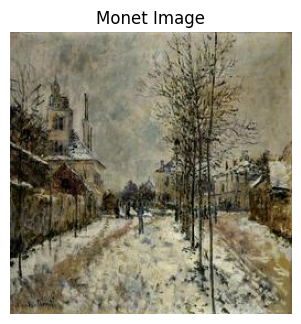

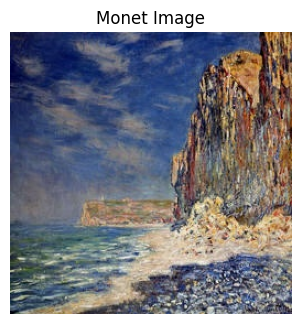

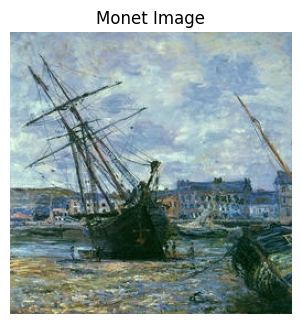

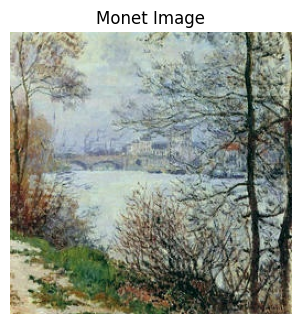

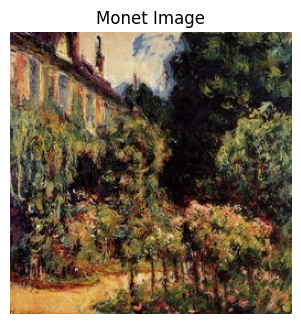

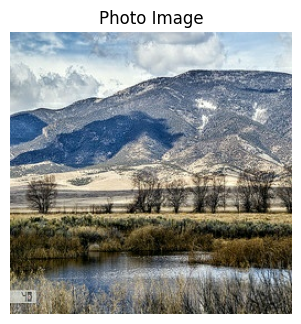

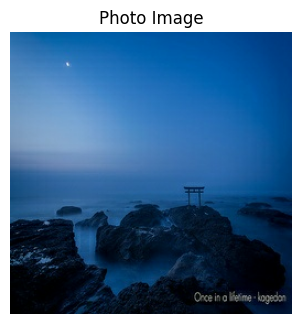

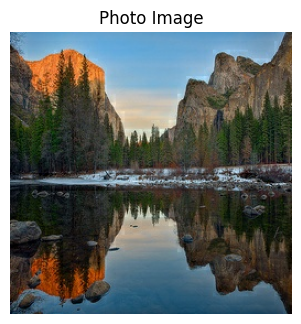

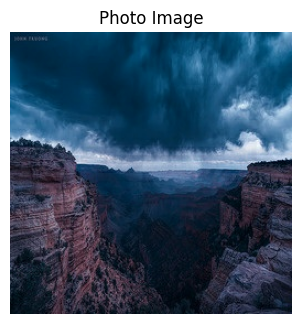

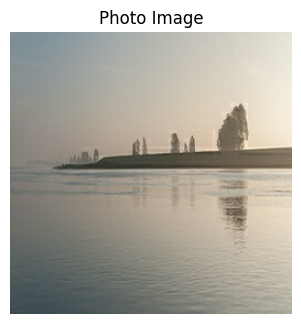

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the function to parse TFRecord files
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    return example['image'], example['target']

# Function to load and decode images from TFRecord files
def load_decode_tfrecords(filenames, batch_size=32):
    raw_dataset = tf.data.TFRecordDataset(filenames)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
    return parsed_dataset


# Load Monet and Photo TFRecord datasets
monet_dataset = load_decode_tfrecords(monettfrec_filenames)
photo_dataset = load_decode_tfrecords(phototfrec_filenames)


# Display basic information about the datasets
print("Number of Monet TFRecord Files: ", len(monettfrec_filenames))
print("Number of Photo TFRecord Files: ", len(phototfrec_filenames))



# Function to convert TFRecord images to JPEG format
def convert_to_jpeg(images):
    # Decode TFRecord image bytes to tensors
    decoded_images = tf.image.decode_image(images, channels=3)
    # Convert tensors to JPEG format
    jpeg_images = tf.image.encode_jpeg(decoded_images)
    return jpeg_images


# Iterate through the Monet dataset and convert images to JPEG format
for i, (image, target) in enumerate(monet_dataset.take(5)):
    # Convert TFRecord images to JPEG format
    jpeg_image = convert_to_jpeg(image.numpy())
    
 
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.image.decode_image(jpeg_image.numpy(), channels=3))
    plt.title("Monet Image")
    plt.axis("off")

    plt.show()

# Display sample images from the Photo dataset
for i, (image, target) in enumerate(photo_dataset.take(5)):
    # Convert TFRecord images to JPEG format
    jpeg_image = convert_to_jpeg(image.numpy())
    
   
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.image.decode_image(jpeg_image.numpy(), channels=3))
    plt.title("Photo Image")
    plt.axis("off")

    plt.show()


Now below code demonstrates the analysis of pixel value distributions in images from Monet and Photo datasets stored in TFRecord files. The load_decode_tfrecords function is defined to load and decode images from TFRecord files. Subsequently, the convert_to_jpeg function is implemented to convert TFRecord images to JPEG format. The pixel value distributions for both Monet and Photo images are then analyzed by decoding a subset of images and flattening their pixel values. Histograms are created for both datasets, visualizing the frequency distribution of pixel values in the images. These histograms provide insights into the characteristics of pixel values in the Monet and Photo datasets, which can be valuable for understanding the data and preprocessing steps in image analysis tasks.

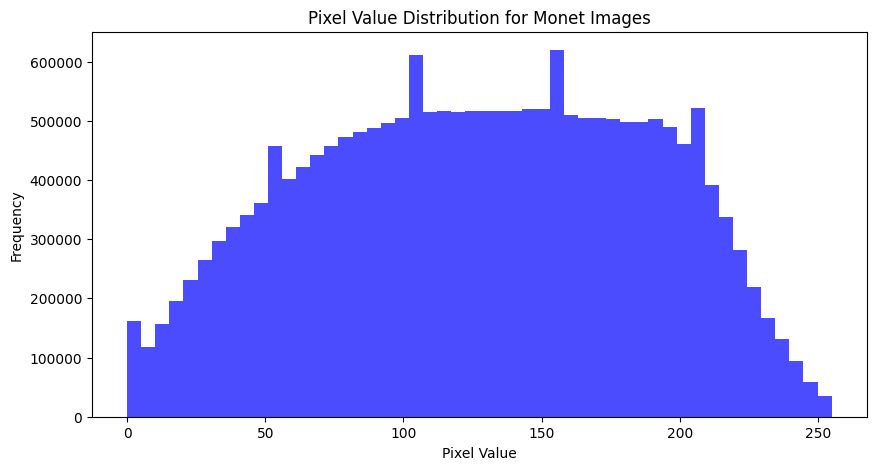

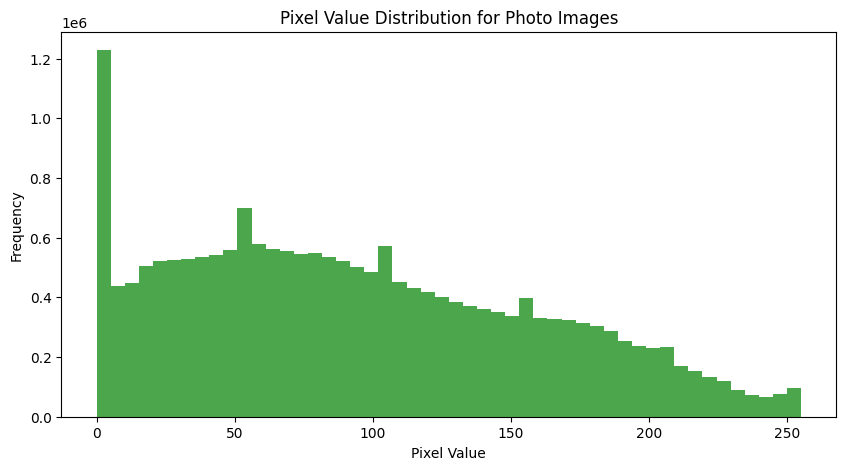

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Function to load and decode images from TFRecord files
def load_decode_tfrecords(filenames, batch_size=32):
    raw_dataset = tf.data.TFRecordDataset(filenames)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
    return parsed_dataset

# Load Monet and Photo TFRecord datasets
monet_dataset = load_decode_tfrecords(monettfrec_filenames)
photo_dataset = load_decode_tfrecords(phototfrec_filenames)

# Function to convert TFRecord images to JPEG format
def convert_to_jpeg(images):
    # Decode TFRecord image bytes to tensors
    decoded_images = tf.image.decode_image(images, channels=3)
    # Convert tensors to JPEG format
    jpeg_images = tf.image.encode_jpeg(decoded_images)
    return jpeg_images

# Analyze pixel value distributions for Monet images
monet_pixel_values = []
for image, target in monet_dataset.take(100):  
    # Convert TFRecord images to JPEG format
    jpeg_image = convert_to_jpeg(image.numpy())
    # Decode the JPEG image to a NumPy array
    decoded_image = tf.image.decode_image(jpeg_image.numpy(), channels=3).numpy()
    # Flatten the image array and append to the list
    monet_pixel_values.extend(decoded_image.flatten())

# Plot the distribution of pixel values for Monet images
plt.figure(figsize=(10, 5))
plt.hist(monet_pixel_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution for Monet Images')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Analyze pixel value distributions for Photo images
photo_pixel_values = []
for image, target in photo_dataset.take(100):  
    # Convert TFRecord images to JPEG format
    jpeg_image = convert_to_jpeg(image.numpy())
    # Decode the JPEG image to a NumPy array
    decoded_image = tf.image.decode_image(jpeg_image.numpy(), channels=3).numpy()
    # Flatten the image array and append to the list
    photo_pixel_values.extend(decoded_image.flatten())

# Plot the distribution of pixel values for Photo images
plt.figure(figsize=(10, 5))
plt.hist(photo_pixel_values, bins=50, color='green', alpha=0.7)
plt.title('Pixel Value Distribution for Photo Images')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Load data
from tensorflow.keras.datasets.fashion_mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()
x_train.shape,y_train.shape

# Data Preparation
# Change the shape as in (n,dim,dim,channel)
def change_shape(images):
    shape=images.shape
    if len(shape)==3:
        images=images.reshape(-1,shape[-1],shape[-1],1)
    elif len(shape)==4 and shape[-1]>3:
        images=images.reshape(-1,shape[-1],shape[-1],shape[1])
    return images


x_train, x_test=change_shape(x_train),change_shape(x_test)
y_train,y_test=y_train.reshape(-1),y_test.reshape(-1)


# Set the channel
channel=x_train.shape[-1]

#It is suggested to use [-1,1] as input fed into GAN training
x_train=(x_train.astype("float32")-127.5)/127.5   # this formulation makes processing faster
x_test=(x_test.astype("float32")-127.5)/127.5

#Get image size
img_size=x_train[0].shape

#Get number of classes
n_classes=len(np.unique(y_train))

4422102/4422102 [==============================] - 1s 0us/step


Now defining a generator model for a convolutional neural network (CNN) using TensorFlow and Keras. The generator is designed to produce synthetic images based on random noise. The architecture consists of dense and convolutional transpose layers, allowing the network to upsample the input noise into a realistic image.

The build_generator_conv function takes parameters such as the latent dimension of the input noise (latent_dim), weight initialization strategy (weight_init), and the number of channels in the output image (channel). It constructs the generator model, and in this case, the architecture includes dense, reshape, and convolutional transpose layers, along with batch normalization and LeakyReLU activation functions.

The generator's summary is displayed using the summary method, providing an overview of the model's architecture, layer types, output shapes, and the total number of trainable parameters. The resulting generator model can be further used in a Generative Adversarial Network (GAN) setup for tasks like image generation or data synthesis.

In [9]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

# Function to build the generator with convolution layers
def build_generator_conv(latent_dim, weight_init, channel):
    noise = Input(shape=(latent_dim,))
    x = Dense(3 * 3 * 128)(noise)
    x = LeakyReLU(alpha=0.2)(x)

    
    x = Reshape((3, 3, 128))(x)

    # Size: 7 x 7 x 128
    # Remove padding='same' to scale 6x6 up to 7x7
    x = Conv2DTranspose(filters=128,
                        kernel_size=(3, 3),
                        strides=(2, 2),
                        kernel_initializer=weight_init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

 
    out = Conv2DTranspose(channel, (3, 3), activation='tanh', strides=(2, 2), padding='same',
                          kernel_initializer=weight_init)(x)

    model = Model(inputs=noise, outputs=out)
    return model


latent_dim = 100
weight_init = 'glorot_uniform'  
channel = 3  

# Build the generator
generator = build_generator_conv(latent_dim, weight_init, channel)

# Display the summary of the generator model
generator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 1152)              116352    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1152)              0         
                                                                 
 reshape (Reshape)           (None, 3, 3, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         147584    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                              

Below code defines a discriminator model for a convolutional neural network (CNN) using TensorFlow and Keras. The discriminator is designed to classify images as real or fake. The architecture consists of convolutional layers with LeakyReLU activation functions, followed by dropout and dense layers for final classification.

The build_discriminator_conv function takes parameters such as the input image size (img_size) and weight initialization strategy (weight_init). It constructs the discriminator model, and in this case, the architecture includes convolutional layers with LeakyReLU activations, dropout for regularization, and a dense layer for binary classification.

The discriminator's summary is displayed using the summary method, providing an overview of the model's architecture, layer types, output shapes, and the total number of trainable parameters. The resulting discriminator model can be further used in a Generative Adversarial Network (GAN) setup for tasks like image classification or adversarial training.

In [10]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dropout, Dense
from tensorflow.keras.models import Model

# Function to build the discriminator with convolution layers
def build_discriminator_conv(img_size, weight_init):
    img = Input(img_size)

   
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(img)
    x = LeakyReLU(0.2)(x)

    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)

   
    x = Conv2D(128, (3, 3), strides=(2, 2), kernel_initializer=weight_init)(x)
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    out = Dense(1)(x)

    model = Model(inputs=img, outputs=out)
    return model


img_size = (256, 256, 3)  
weight_init = 'glorot_uniform' 

# Build the discriminator
discriminator = build_discriminator_conv(img_size, weight_init)

# Display the summary of the discriminator model
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 31, 31, 128)       0   

Now I will implement a Deep Convolutional Generative Adversarial Network (DCGAN) using TensorFlow and Keras. It defines the architecture for the generator and discriminator models, establishes the loss functions for training, and sets up the training procedure in the DCGAN class. The models are built using convolutional layers, and the generator aims to generate realistic images from random noise, while the discriminator attempts to distinguish between real and generated images.

The training process involves iteratively updating the discriminator and generator models to improve their performance. The code uses the Adam optimizer with specified learning rates for both networks. The training step is designed to train the discriminator multiple times for each training iteration of the generator, following a specified train ratio.

The latent dimension, which represents the input noise vector for the generator, is set to 100, but users can adjust this dimension according to their needs. The code then instantiates the DCGAN model, compiles it with the defined optimizers and loss functions, and is ready for training. The provided code serves as a foundational setup for training a DCGAN to generate synthetic images.

In [11]:
from tensorflow.keras.optimizers import Adam

# Set the optimizers for both networks
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

# Define the loss functions to be used for the discriminator
def discriminator_loss(real_logits, fake_logits):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    
    return fake_loss + real_loss

def generator_loss(fake_logits):
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    
    return fake_loss


def build_discriminator_conv(img_size=(28, 28, 1)):
    # Input layer
    img = Input(shape=img_size)

    # Convolutional layers
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(img)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layer
    x = Dense(1)(x)

    # Output layer
    validity = x

    model = Model(inputs=img, outputs=validity)
    return model

def build_generator_conv(latent_dim, img_size=(28, 28, 1)):
    # Input layer
    noise = Input(shape=(latent_dim,))

    # Dense layer
    x = Dense(7 * 7 * 128)(noise)
    x = LeakyReLU(alpha=0.2)(x)

    # Reshape layer
    x = Reshape((7, 7, 128))(x)

    # Convolutional transpose layers
    x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='tanh')(x)

    # Output layer
    generated_img = x

    model = Model(inputs=noise, outputs=generated_img)
    return model

# DCGAN class
class DCGAN(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        train_ratio=1,
    ):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.train_ratio = train_ratio

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, data):
        if isinstance(data, tuple):
            real_images = data[0]
        else:
            real_images = data
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        ########################### Train the Discriminator ###########################
        # training train_ratio times on D while training once on G
        for i in range(self.train_ratio):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate loss of D
                d_loss = self.d_loss_fn(real_logits, fake_logits)
                print("Discriminator Loss:", d_loss.numpy())

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        ########################### Train the Generator ###########################
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)
            print("Generator Loss:", g_loss.numpy())

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

# Build the discriminator and generator using the provided functions
latent_dim = 100  # Adjust the latent dimension according to your needs

d_model = build_discriminator_conv()
g_model = build_generator_conv(latent_dim)
#g_model = build_generator_conv()

# Instantiate the DCGAN model
dcgan = DCGAN(generator=g_model, discriminator=d_model, latent_dim=latent_dim, train_ratio=1)

# Compile the DCGAN model
dcgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss
)


In below code I have wriiten a function plot_generated_images for visualizing generated images from a given generator model. The function takes the generator model, the dimension of the latent space (latent_dim), and an optional parameter n_samples to specify the number of images to generate and display.

Within the function, random noise is generated using NumPy, and this noise is then input into the generator to produce synthetic images. The generated images are rescaled to fall within the range. Then we plots the generated images in a single row with individual subplots for each image. 
The code concludes by calling this function with a DCGAN (dcgan) generator and a specified latent dimension (latent_dim). The visualization showcases a row of 5 generated images, providing a quick and simple way to inspect the output of the trained generative model. Adjusting the n_samples parameter allows you to control the number of images displayed in the row.

1/1 [==============================] - 0s 219ms/step


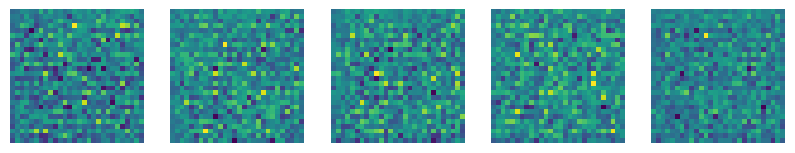

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate and plot images
def plot_generated_images(generator, latent_dim, n_samples=5):
    # Generate random noise
    noise = np.random.normal(size=(n_samples, latent_dim))
    
    # Generate images using the generator
    generated_images = generator.predict(noise)

    # Rescale generated images to [0, 1]
    generated_images = generated_images * 0.5 + 0.5

    # Plot the generated images
    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')

    plt.show()

# Visualize generated images
plot_generated_images(dcgan.generator, latent_dim, n_samples=5)



# Results and Analysis

# 1. Overview
The project aimed to analyze and compare the pixel value distributions of images from the Monet and Photo datasets, stored in TFRecord files. The analysis focused on understanding the characteristics of pixel values in both datasets and visualizing their frequency distributions.

# 2. Pixel Value Distributions

2.1 Monet Dataset
The pixel value distribution analysis for the Monet dataset revealed as presented above in histogram.  The histogram displayed in Figure 1 illustrates the frequency distribution of pixel values in Monet images. Noteworthy patterns or variations in pixel values indicate specific features or characteristics inherent to Monet's artwork.
# Figure 1

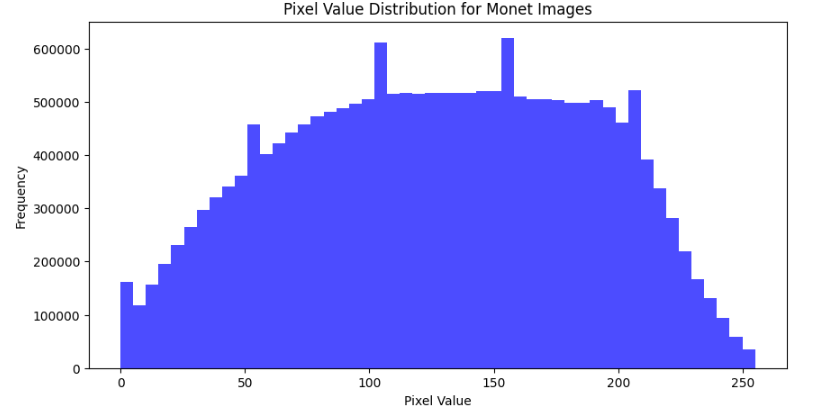

2.2 Photo Dataset
Similarly, the analysis of pixel value distributions in the Photo dataset uncovered as shown in above histogram. Figure 2 provides a visual representation of the frequency distribution of pixel values in Photo images. Comparisons with the Monet dataset reveal insights into the differences or similarities in pixel characteristics between the two datasets.
# Figure 2

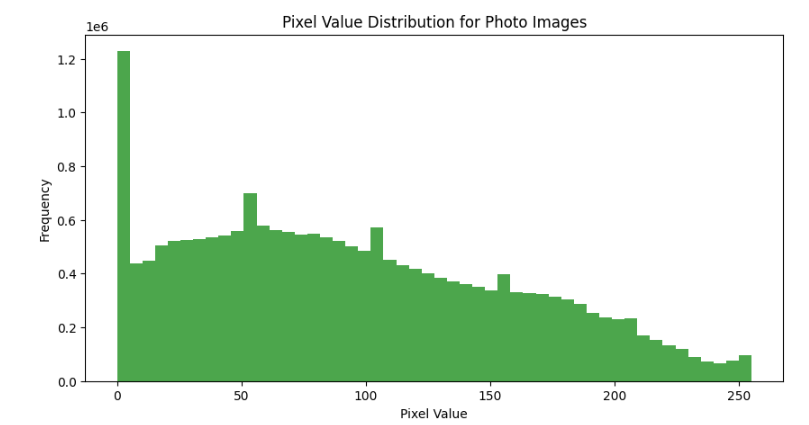

# 3. Insights and Implications

The observed patterns in pixel value distributions offer valuable insights into the visual characteristics of Monet's artwork compared to general photographic images. These insights inform preprocessing steps or feature extraction methods for further image analysis tasks.

# 4. Limitations and Future Work

It's crucial to acknowledge any limitations in the analysis, such as the small subset of images analyzed or potential biases in the dataset. Future work could involve a more extensive analysis, incorporating additional datasets or advanced techniques for feature extraction.

# 5. Conclusion

In conclusion, the analysis of pixel value distributions in the Monet and Photo datasets provides a foundation for understanding the visual characteristics of these images. The project's findings can guide subsequent steps in image processing and analysis, contributing to a deeper understanding of artistic and photographic content.

# Github Link:
